In [109]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import networkx as nx
from functools import reduce
import pandas as pd
import shutil
import sys
import json
import os.path
from pyomo.environ import *
from pyomo.gdp import *
import time 
from pyomo.contrib.latex_printer import latex_printer
import importlib
import script
import wrapt_timeout_decorator
# from IPython.display import display, Math, Latex

In [110]:
def WriteJson(dictionary: dict, name = "task.json"):
    with open(name, 'w') as f:
        json.dump(dictionary, f)
    
def ReadJson(name = "task.json") -> dict:
    with open(name, 'r') as f:
        m = json.loads(f.read())
        return m

In [111]:
def Gantt(JOBS, SCHEDULE={}, ax1=None, ax2=None):
    bw = 0.3
#     ax.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax1.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax1.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    ax1.set_ylim(-0.5, idx-0.5)
    ax1.set_title('Job Schedule')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Jobs')
    ax1.set_yticks(range(len(JOBS)), JOBS.keys())
    ax1.grid()
    xlim = ax1.get_xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

#         ax.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax2.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax2.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax2.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        ax2.set_xlim(xlim)
        ax2.set_ylim(-0.5, len(MACHINES)-0.5)
        ax2.set_title('Machine Schedule')
        ax2.set_yticks(range(len(MACHINES)), MACHINES)
        ax2.set_ylabel('Machines')
        ax2.grid()

def Kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

In [112]:
#Создание метода решения
@wrapt_timeout_decorator.timeout(5)
def ScheduleMachines(JOBS, MACHINES):
    from pyomo.environ import ConcreteModel, Set, Var, NonNegativeReals, Binary, Constraint, Objective, SolverFactory, minimize

    # Создание модели pyomo
    m = ConcreteModel()

    # инициализация основных списков модели.
    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    # инициализация переменных модели с ограничениями на значения (от 0 до 1000) или NonNegativeReals
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)

    #разницы между реальным окончанием работы и директивным
    m.pastdue    = Var(m.J, domain=NonNegativeReals)
    m.early      = Var(m.J, domain=NonNegativeReals)

    # переменные модели которые будут использоваться в ограничениях
    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # матрица бинарного соответствия работ машинам
    m.z = Var(m.J, m.M, domain=Binary)

    # for modeling disjunctive constraints
    m.y = Var(m.PAIRS, domain=Binary)

    BigM = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    #задание функции которую необходимо минимизировать. В данном случае - время окончание всех работ.
    m.OBJ = Objective(expr = m.makespan, sense = minimize)


    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])

    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])

    #задание условия, что одна работа не может выполняться на нескольких машинах. Внимание стоит обратить на синтаксис без if
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)

    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])

    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= m.maxpastdue)


    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] <= m.makespan)

    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))

    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))


    #в следующием коде задаётся граф выполнения работ
    i = 1
    for job in JOBS:
        for dependency in JOBS[job]["dependencies"]:
            setattr(m, f"c_{6 + i}", Constraint(expr = m.start[dependency] >= (m.start[job] + JOBS[job]['duration'])))
            i += 1

    #метод решения
    result = SolverFactory('glpk',executable=r"C:\glpk\glpk-4.65\w32\glpsol.exe").solve(m)
#     result.write()

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + JOBS[j]['duration'],
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE, m

## Алгоритм

In [113]:
def Roots(graph: dict):
    roots = list(set(graph.keys()) - set(reduce(lambda x, y: x + y , graph.values(), [])))
    sorted(roots, key=lambda x: -len(graph[x]))
    return roots

def Cut(graph: dict, roots: list, topn: int):
    assert(topn > 0)
    result = graph.copy()
    cutted = []
    
    for i in roots:
        result.pop(i)
        cutted.append(i)
        topn -= 1
        
        if topn == 0:
            break
    
    return result, cutted

def Sheduler(answer: list, jobs: dict, machines: list):
    result = {}
    start_time = jobs[next(iter(jobs))]["release"]
    duration = jobs[next(iter(jobs))]["duration"]
    
    for i, bucket in enumerate(answer):
        for j, job in enumerate(bucket):
            result[job] = {
                'start': float(start_time + i * duration),
                'finish': float(start_time + (i + 1) * duration),
                'machine': machines[j],
            }
    
    return result

def Solve(jobs: dict, machines: list):
    graph = {i: jobs[i]["dependencies"] for i in jobs}
    
    answer = []
    while graph:
        roots = Roots(graph)
        graph, cutted = Cut(graph, roots, len(machines))
        answer.append(cutted)
    
    return Sheduler(answer, jobs, machines)

---

In [114]:
def Test(name, verbose = False):
    DATA = ReadJson(name=name)

    #Задание спика машин
    MACHINES = DATA["MACHINES"]

    #Задание словаря работ
    JOBS = DATA["JOBS"]

    g = nx.DiGraph()
    for i in JOBS:
        g.add_node(i)
        for j in JOBS[i]["dependencies"]:
            g.add_edge(i, j)

    start2 = time.time()
    SCHEDULE2 = Solve(JOBS, MACHINES)
    end2 = time.time()
    try:
        start1 = time.time()
        SCHEDULE1, MODEL = ScheduleMachines(JOBS, MACHINES)
        end1 = time.time()
    except:
        return None, Kpi(JOBS, SCHEDULE2)['Makespan'], 5.0, (end2-start2), len(g.edges())
    
    
    if not verbose:
        fig, ax = plt.subplots(3, 2, figsize=(15,14))
        fig.suptitle(f"{name}")
        ax[0][0].get_xaxis().set_visible(False)
        ax[0][0].get_yaxis().set_visible(False)
        ax[0][0].set_axis_off()
        ax[0][0].text(0.5, 0.5, f"Best: {Kpi(JOBS, SCHEDULE1)['Makespan']}\n"
                     f"Greedy: {Kpi(JOBS, SCHEDULE2)['Makespan']}")

        nx.draw_networkx(g, ax=ax[0][1])
        Gantt(JOBS, SCHEDULE1, ax[1][0], ax[2][0]) 
        Gantt(JOBS, SCHEDULE2, ax[1][1], ax[2][1])

    return Kpi(JOBS, SCHEDULE1)['Makespan'], Kpi(JOBS, SCHEDULE2)['Makespan'], (end1-start1), (end2-start2), len(g.edges())

In [115]:
df = pd.DataFrame(columns=["Edge Count", "Cmax", "my Cmax", "Delta", "Time 1", "Time 2"])
for m in range(20):
    WriteJson(script.create_task(3, 10, 1, 1, 12, m=m+12))
    v1, v2, t1, t2, edge_count = Test("task.json", verbose = True)
    df.loc[m] = [edge_count, v1, v2, abs(v2-v1) if v1 is not None else None, t1, t2]
    print(f"[{m}] Time: {t1 + t2}")

[0] Time: 3.814924716949463
[1] Time: 3.5197339057922363
[2] Time: 2.9053995609283447
[3] Time: 3.288722038269043
[4] Time: 3.559314489364624
[5] Time: 3.035397529602051
[6] Time: 1.4758076667785645
[7] Time: 1.5796406269073486
[8] Time: 1.5258440971374512
[9] Time: 1.4925305843353271
[10] Time: 1.7654881477355957
[11] Time: 1.3990235328674316
[12] Time: 1.198153018951416
[13] Time: 1.1860582828521729
[14] Time: 1.09847092628479
[15] Time: 1.22444486618042
[16] Time: 1.1194322109222412
[17] Time: 1.1601855754852295
[18] Time: 1.236379623413086
[19] Time: 1.2566087245941162


In [116]:
df

,Edge Count,Cmax,my Cmax,Delta,Time 1,Time 2
0,12.0,6.0,6.0,0.0,3.814925,0.000
1,13.0,6.0,6.0,0.0,3.519734,0.000
2,14.0,6.0,6.0,0.0,2.905400,0.000
3,15.0,7.0,7.0,0.0,3.288722,0.000
4,16.0,7.0,7.0,0.0,3.559314,0.000
5,17.0,9.0,9.0,0.0,3.035398,0.000
6,18.0,11.0,11.0,0.0,1.475808,0.000
7,19.0,9.0,9.0,0.0,1.579641,0.000
8,20.0,9.0,9.0,0.0,1.525844,0.000
9,21.0,9.0,9.0,0.0,1.492531,0.000


(6.0, 6.0, 1.1679136753082275, 0.0, 7)

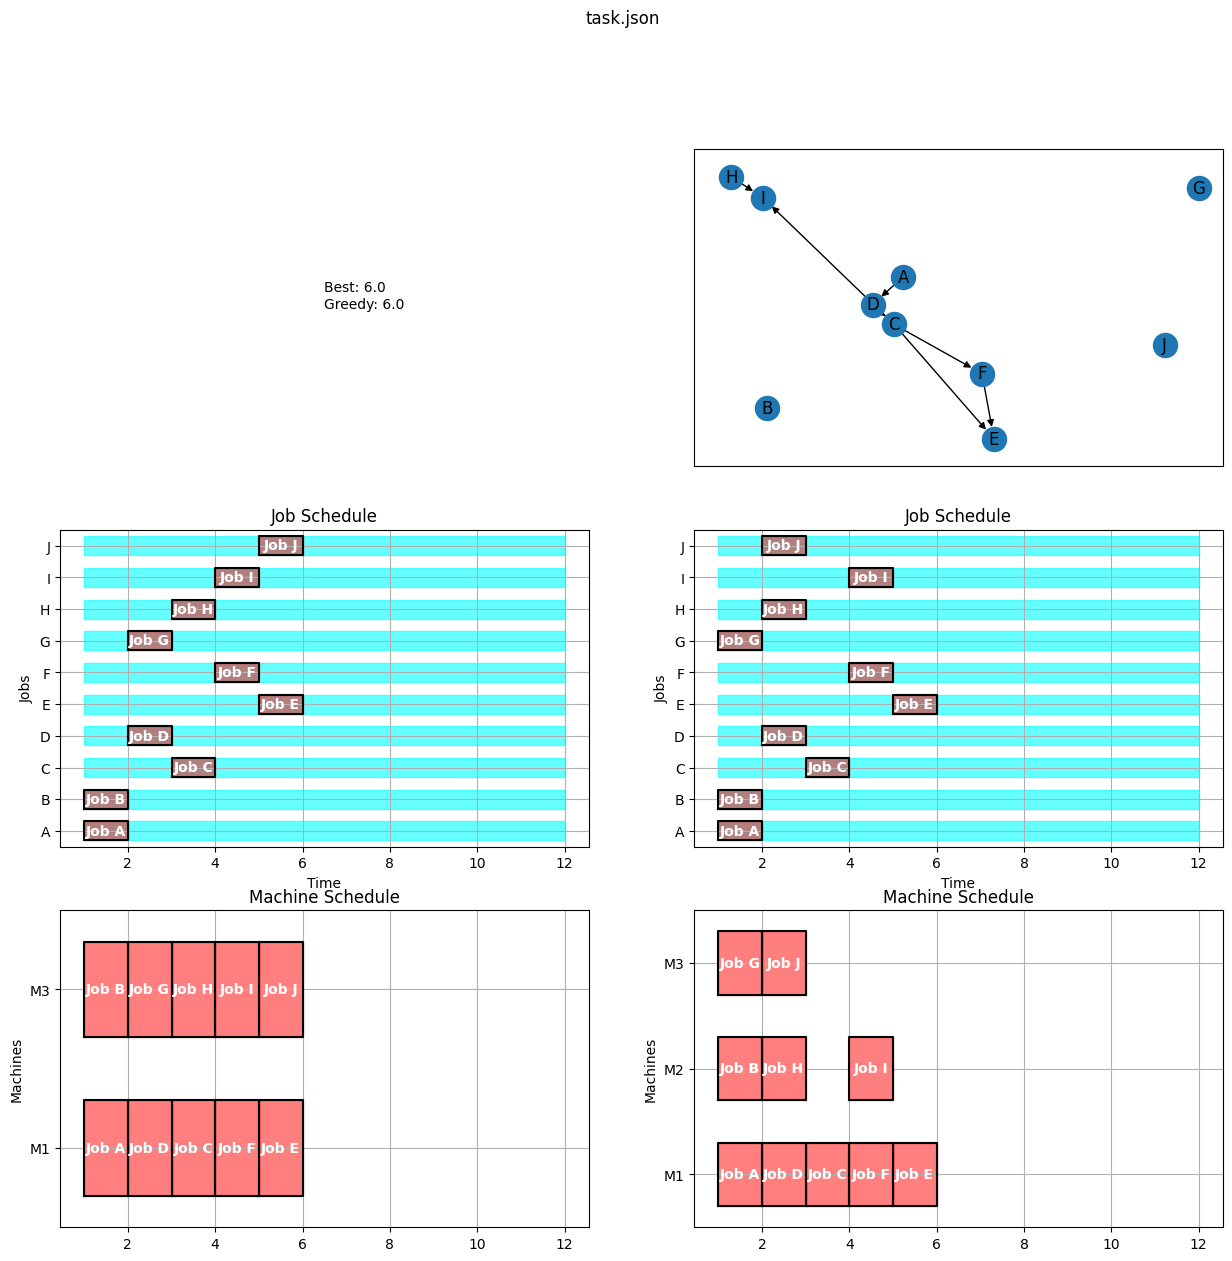

In [118]:
WriteJson(script.create_task(3, 10, 1, 1, 12, m=7))
Test("task.json")